In [87]:
using PyPlot, Printf, Printf

include("decode.jl")
include("utils.jl")
include("inference.jl")

include("UpdateRule.jl")
include("Leaky.jl")
include("VarSMiLe.jl")
include("ParticleFiltering.jl")
;

In [20]:
function decode_surprise_with_inference(seq, rule, prior)
    # define callback
    function callback(r, x_t, col)
        surprise = r.getsbf(x_t, col)
        theta = r.gettheta(col)
        return (surprise, theta)
    end
    
    cb = Callback(callback, Tuple{Float64,Float64})

    # decode sequence
    result = decode_with_inference(seq, rule, prior, cb)
    
    return map(r -> r[1], result), map(r -> r[2], result)
end
;

In [46]:
function decode_surprise(seq, m, alpha_0, rule)
    # define callback
    function callback(r, x_t, col)
        surprise = r.getsbf(x_t, col)
        theta = r.gettheta(col)
        return (surprise, theta)
    end
    
    cb = Callback(callback, Tuple{Float64,Float64})

    # decode sequence
    result = decode(seq, m, alpha_0, rule, cb)
    
    return map(r -> r[1], result), map(r -> r[2], result)
end
;

In [3]:
function plot_surprise(surprises, start, stop, params)
    len = length(surprises)

    # plot
    xall = range(1, len, length=len)
    x = xall[start:stop]
    y = surprises[start:stop]
    
    plot(x, y, label=@sprintf("m = %i", params["m"]))
    xlabel("t")
    ylabel("S_{BF}")
    title(@sprintf("%s using update rule %s", params["title"], params["rule"]))
    grid("on")
    legend()
end
;

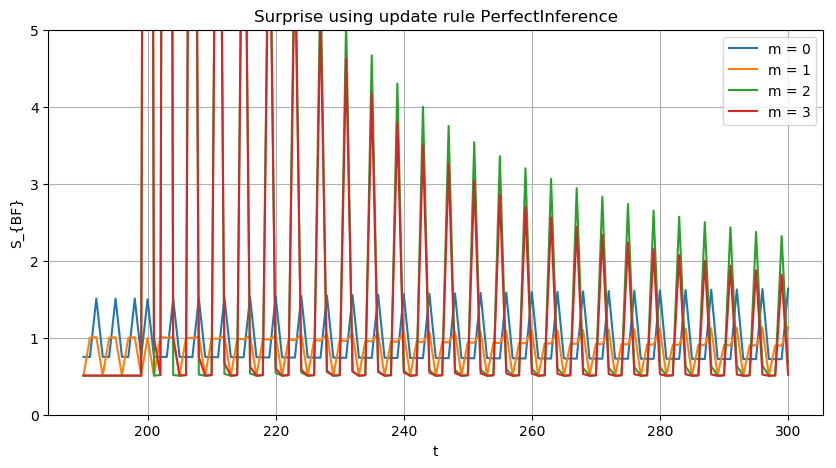

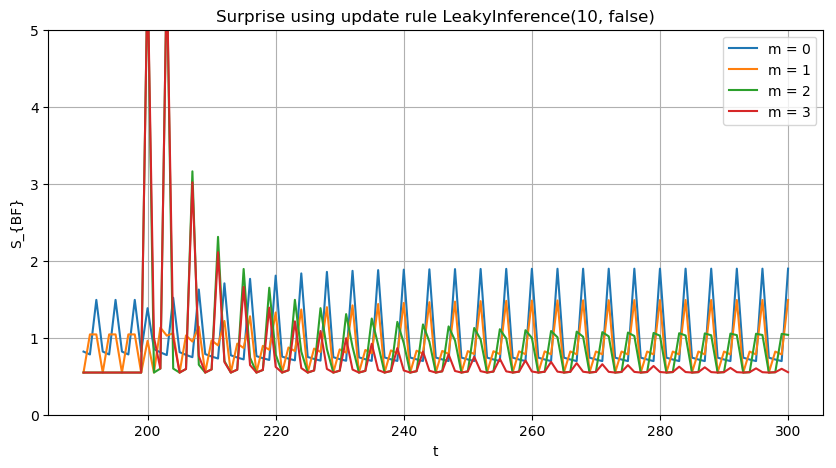

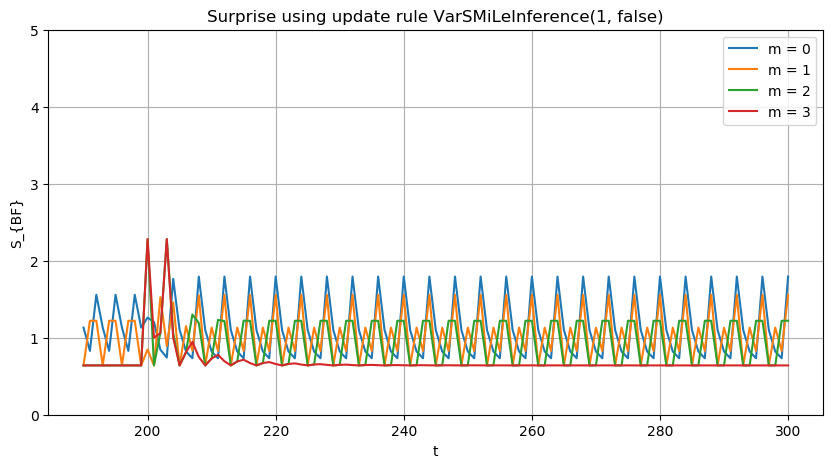

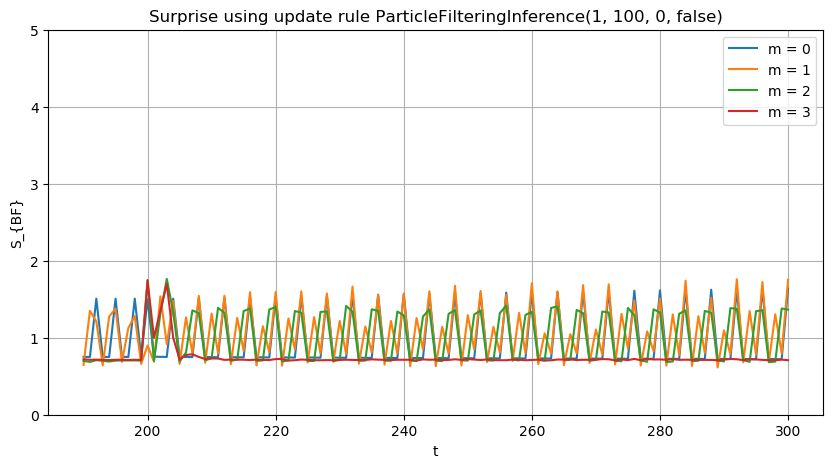

In [92]:
# generate sequence { 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 ... }
len = 400
seq = Int.(ones(len))
for i = 1:len÷2
    seq[i] = i % 3 == 0
end

for i = len÷2:len
    seq[i] = i % 4 == 0
end

# plot parameters
start = 190
stop = 300

# rules to plot
rules = [LeakyInference(Inf), LeakyInference(10), VarSMiLeInference(1), ParticleFilteringInference(1, 100, 0)]
priors = map(prior_fixed, [0, 1, 2, 3])

for (rule, name) in zip(rules, names)
    # reset figure
    fig, ax = subplots(figsize=(10,5))

    for prior in priors

        # decode sequence
        surprises, thetas = decode_surprise_with_inference(seq, rule, prior)

        # plot surprises
        params = Dict("title" => "Surprise", "m" => length(prior) - 1, "rule" => rule.str)
        plot_surprise(surprises, start, stop, params)
        
        # add y lim
        ax = gca()    
        ax.set_ylim([0,5])
    end
end

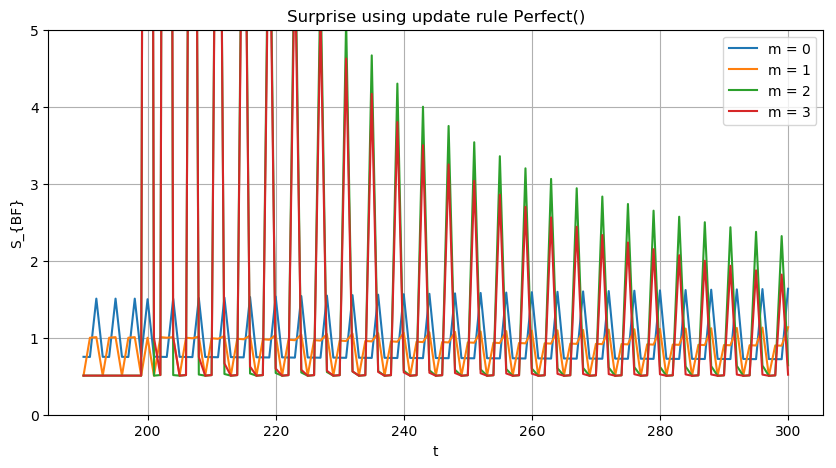

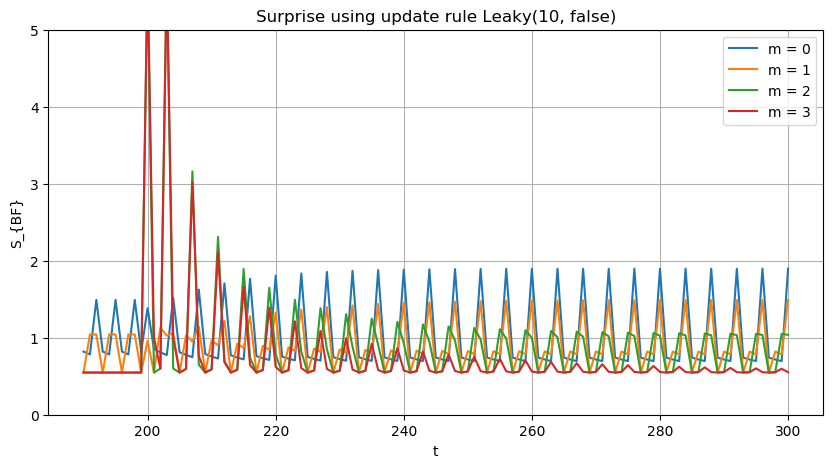

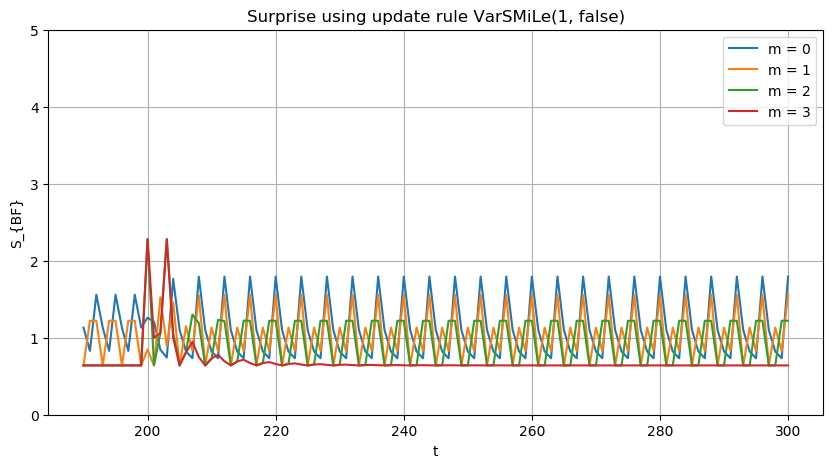

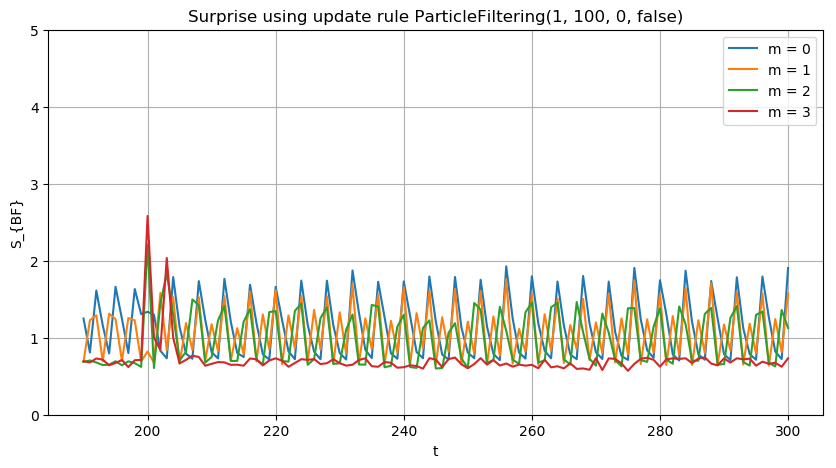

In [91]:
# generate sequence { 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 ... }
len = 400
seq = Int.(ones(len))
for i = 1:len÷2
    seq[i] = i % 3 == 0
end

for i = len÷2:len
    seq[i] = i % 4 == 0
end

# plot parameters
start = 190
stop = 300

# rules to plot
rules = [Perfect(), Leaky(10), VarSMiLe(1), ParticleFiltering(1, 100, 0)]
names = [r.str for r in rules]
m_values = [0, 1, 2, 3]

var_params_s = nothing

for (rule, name) in zip(rules, names)
    # reset figure
    fig, ax = subplots(figsize=(10,5))

    for m in m_values
                
        # define initial params
        alpha_0 = ones(2, 2^m)

        # decode sequence
        surprises, thetas = decode_surprise(seq, m, alpha_0, rule)

        # plot surprises
        params = Dict("title" => "Surprise", "m" => m, "rule" => name)
        plot_surprise(surprises, start, stop, params)
        
        # add y lim
        ax = gca()    
        ax.set_ylim([0,5])
    end
end

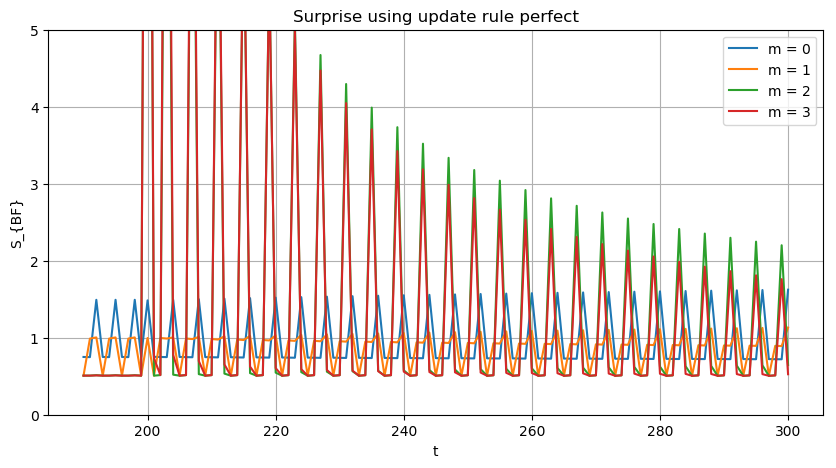

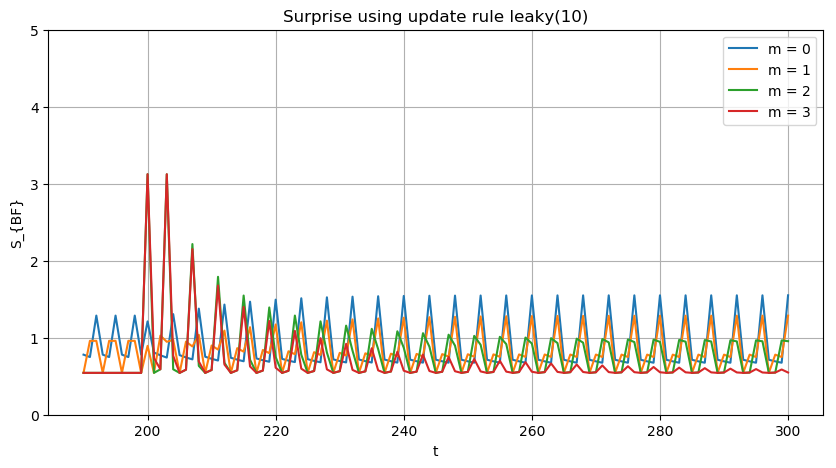

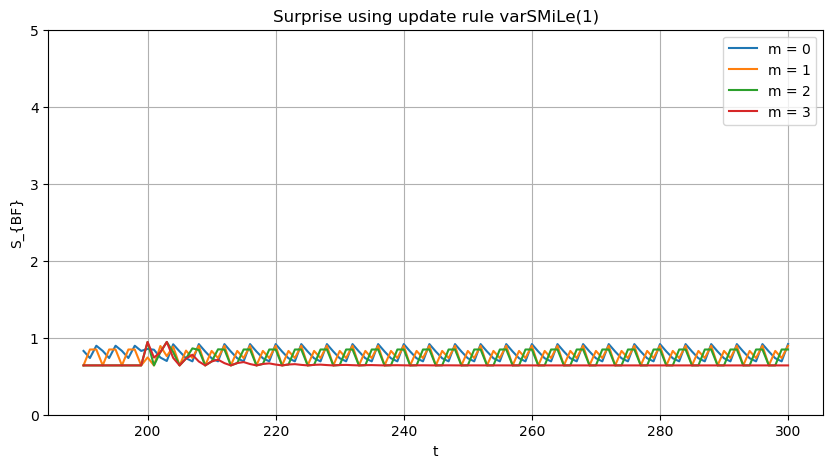

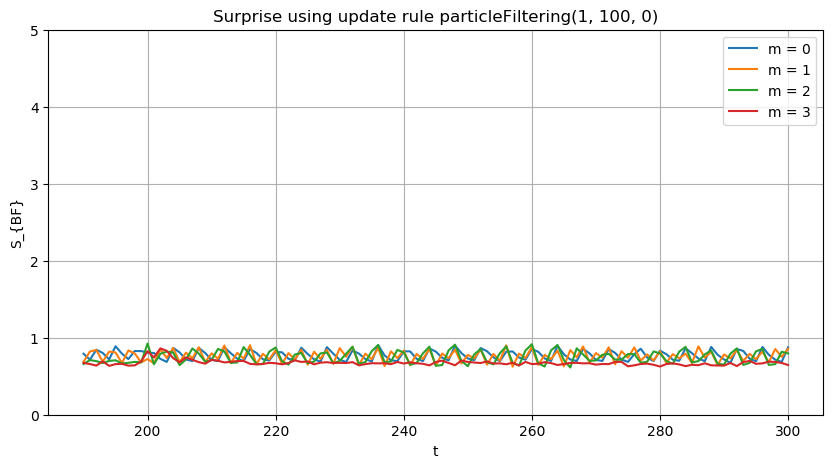

In [44]:
# generate sequence { 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 ... }
len = 400
seq = Int.(ones(len))
for i = 1:len÷2
    seq[i] = i % 3 == 0
end

for i = len÷2:len
    seq[i] = i % 4 == 0
end

# plot parameters
start = 190
stop = 300

# rules to plot
rules = [Perfect(), Leaky(10), VarSMiLe(1), ParticleFiltering(1, 100, 0)]
names = [r.str for r in rules]
m_values = [0, 1, 2, 3]

for (rule, name) in zip(rules, names)
    # reset figure
    fig, ax = subplots(figsize=(10,5))

    for m in m_values
                
        # define initial params
        alpha_0 = ones(2, 2^m)

        # decode sequence
        surprises, thetas = decode_surprise(seq, m, alpha_0, rule)

        # plot surprises
        params = Dict("title" => "Surprise", "m" => m, "rule" => name)
        plot_surprise(surprises, start, stop, params)
        
        # add y lim
        ax = gca()    
        ax.set_ylim([0,5])
    end
end

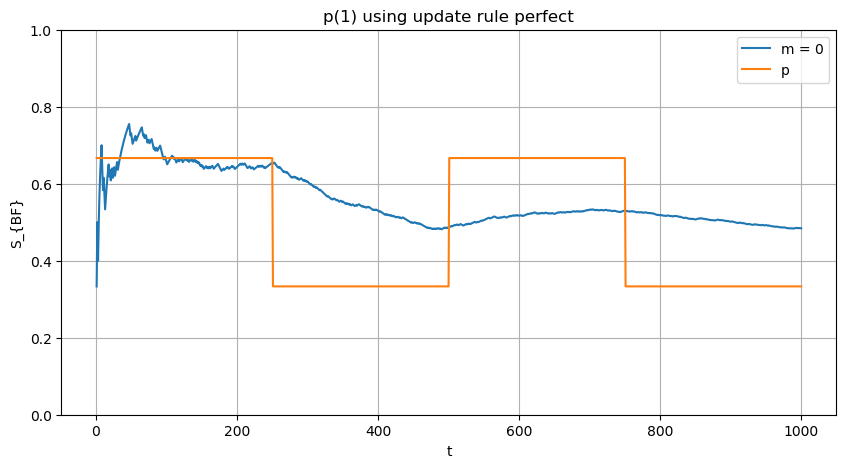

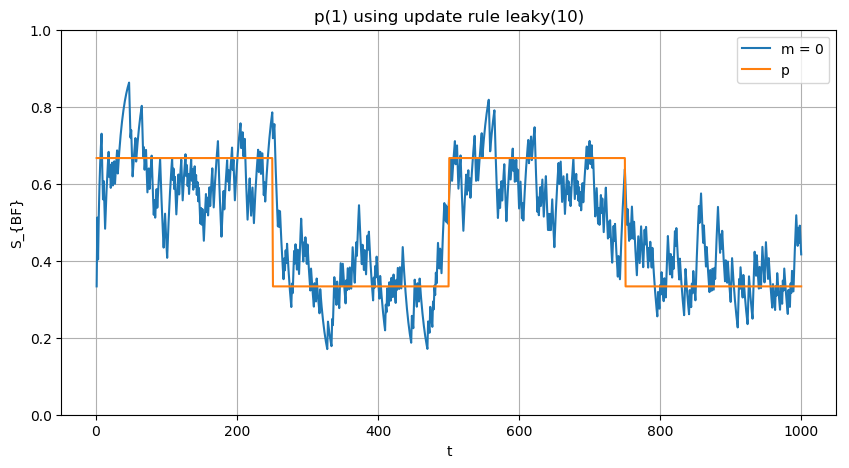

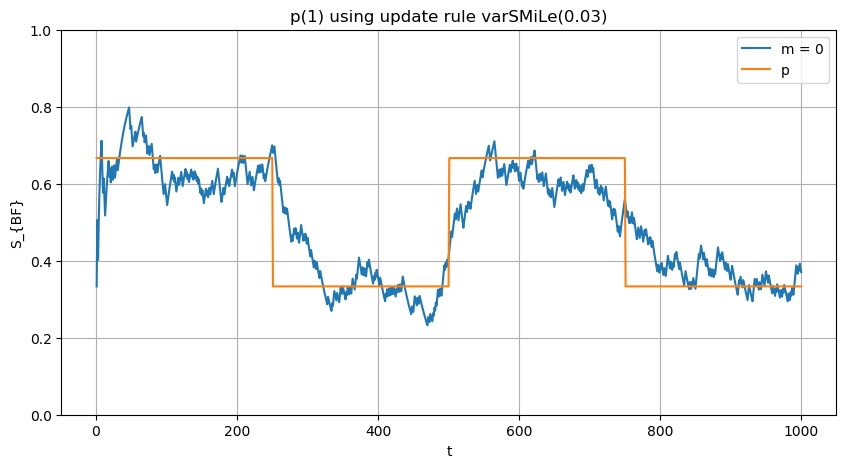

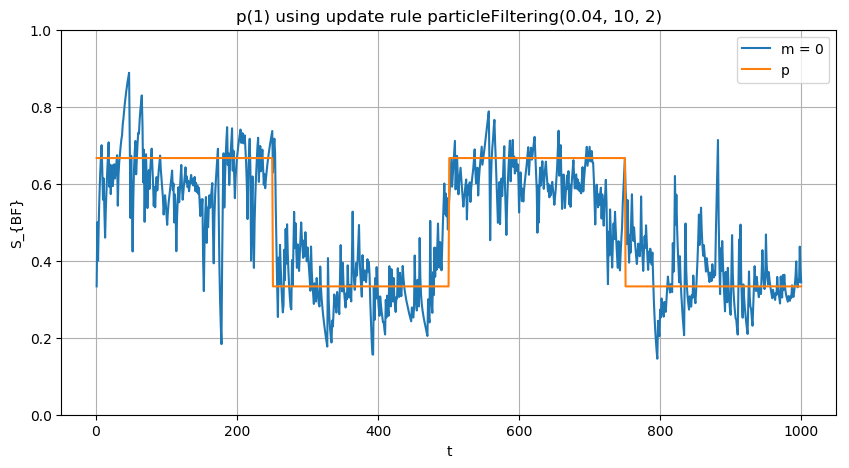

In [37]:
# generate sequence
len = 1000
seq = Array{Int32}(undef, len)

phigh = 2.0/3.0 * ones(250)
plow = 1.0/3.0 * ones(250)
p = vcat(phigh, plow, phigh, plow)

for i = 1:len
    seq[i] = rand() > p[i]
end

# plot parameters
start = 1
stop = 1000

# rules to plot
rules = [Perfect(), Leaky(10), VarSMiLe(1), ParticleFiltering(1, 100, 0)]
names = [r.str for r in rules]
m = 0

for (rule, name) in zip(rules, names)
    # reset figure
    fig, ax = subplots(figsize=(10,5))
                
    # define initial params
    alpha_0 = ones(2, 2^m)

    # decode sequence
    surprises, thetas = decode_surprise(seq, m, alpha_0, rule)

    # plot surprises
    params = Dict("title" => "p(1)", "m" => m, "rule" => name)
    plot_surprise(thetas, start, stop, params)
    
    # add p
    plot(range(1, len, length=len)[start:stop], p, label="p")
    legend()
    
    # add y limits from 0 - 1
    ax = gca()    
    ax.set_ylim([0,1])
end